# Analyzing Covid19 from public accessible data
In this notebook, I will use the public data to see what the situation is now.

## 1 - Import libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from countryinfo import CountryInfo

## 2 - Import global data by url

In [212]:
confirmed_global=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_global=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_global=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
print ("The lastest global data is: ",confirmed_global.columns[-1])

The lastest global data is:  4/7/20


## 3 - Get the data for a specific country/region

In [202]:
def get_country_data(country_name):
    confirmed=np.array(np.sum(confirmed_global[confirmed_global['Country/Region'].str.contains(country_name)].iloc[:,4:]))
    date=np.array(confirmed_global[confirmed_global['Country/Region'].str.contains(country_name)].iloc[:,4:].columns,dtype=str)
    deaths=np.array(np.sum(deaths_global[deaths_global['Country/Region'].str.contains(country_name)].iloc[:,4:]))
    recovered=np.array(np.sum(recovered_global[recovered_global['Country/Region'].str.contains(country_name)].iloc[:,4:]))
    country_data=[date,confirmed,deaths,recovered]
    return country_data

## 4 - Calculate the derivatives

In [204]:
def get_derivatives(data):
    d=np.zeros(data.shape,dtype=data.dtype)
    d[0]=data[0]
    for i in range(len(data)-1):
        d[i+1]=data[i+1]-data[i]
    return d

## 4.1 - Smearing

In [205]:
def smearing(data,days):
    data=np.array(data)
    tmp=np.zeros(len(data),dtype=data.dtype)
    if len(data)>=2*days+1:
        for i in range(days):
            tmp[i]=np.average(data[:i+days+1])
        for i in range(days,len(data)-days):
            tmp[i]=np.average(data[i-days:i+days+1])
        for i in range(len(data)-days,len(data)):
            tmp[i]=np.average(data[i-days:])
        return tmp
    else:
        return data

## 5 - Plot multiple countries

In [206]:
def plot_countries(countries_names,days=30,plot=["d"],figsize=(9,7.2),smear_days=0,end_day=0,rescale=False):
    
    plt.figure(figsize=figsize)
    
    SMALLER_SIZE = 12
    SMALL_SIZE = 15
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30
    title_size=20
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    markercycle = cycler(marker=['o', 'v',7, 'x', '<', '.', '>','D','^','s'])
    colorcycle = cycler(color=colors)
    plt.gca().set_prop_cycle(markercycle+colorcycle)
    for country_name in countries_names:
        country_data=get_country_data(country_name)
        date=country_data[0]
        
        if country_name=="US":
            country_name="United States"
        if "Korea" in country_name:
            country_name="South Korea"
        
        per=1000000
        if rescale==True:
            scale=1.0/CountryInfo(country_name).population()*per
        else:
            scale=1.0
            
        for i in range(len(date)):
            date[i]=date[i][:-3]
        
        confirmed=country_data[1]*scale
        deaths=country_data[2]*scale
        recovered=country_data[3]*scale
        
        open_cases=confirmed-deaths-recovered
        d_confirmed=get_derivatives(confirmed)
        d_confirmed=smearing(d_confirmed,smear_days)
        d_deaths=get_derivatives(deaths)
        d_deaths=smearing(d_deaths,smear_days)
        d_recovered=get_derivatives(recovered)
        d_recovered=smearing(d_recovered,smear_days)
        d_open_cases=get_derivatives(open_cases)
        d_open_cases=smearing(d_open_cases,smear_days)
        length=len(confirmed)
        x=range(days-end_day)
        if "c" in plot:
            plt.plot(confirmed[-days:length-end_day],label=country_name +" confirmed")
            plt.title("Covid-19 Confirmed Cases by Countries",fontsize=title_size)
        if "d" in plot:
            plt.plot(deaths[-days:length-end_day],label=country_name +" deaths")
            plt.title("Covid-19 Deaths by Countries",fontsize=title_size)
        if "r" in plot:
            plt.plot(recovered[-days:length-end_day],label=country_name +" recovered")
            plt.title("Covid-19 Recovered Cases by Countries",fontsize=title_size)
        if "o" in plot:
            plt.plot(open_cases[-days:length-end_day],label=country_name +" active")
            plt.title("Covid-19 Active Cases by Countries",fontsize=title_size)
        if "dc" in plot:
            plt.plot(d_confirmed[-days:length-end_day],label=country_name +" confirmed daily")
            plt.title("Covid-19 Confirmed Cases Daily by Countries",fontsize=title_size)
        if "dd" in plot:
            plt.plot(d_deaths[-days:length-end_day],label=country_name +" deaths daily")
            plt.title("Covid-19 Deaths Daily by Countries",fontsize=title_size)
        if "dr" in plot:
            plt.plot(d_recovered[-days:length-end_day],label=country_name +" recovered daily")
            plt.title("Covid-19 Recovered Cases Daily by Countries",fontsize=title_size)
        if "do" in plot:
            plt.plot(d_open_cases[-days:length-end_day],label=country_name +" active cases daily")
            plt.title("Covid-19 Open Cases Daily by Countries",fontsize=title_size)
        if len(plot)>1 and len(countries_names)!=1:
            plt.title("Covid-19 by Countries",fontsize=title_size)
        if len(countries_names)==1:
            plt.title("Covid-19 in "+countries_names[0],fontsize=title_size)
    
    my_xticks=date[-days:length-end_day]
    frequency=1
    if days-end_day > 40:
        frequency=2
    plt.xticks(x[::frequency], my_xticks[::frequency])
#     plt.xticks(x, plot_dates)
    plt.xticks(rotation=45)
#     plt.ylim([0,6000])
#     plt.xlabel('date')
    if rescale==True:
        plt.ylabel("Cases Per One Million")
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()

### Plot the world

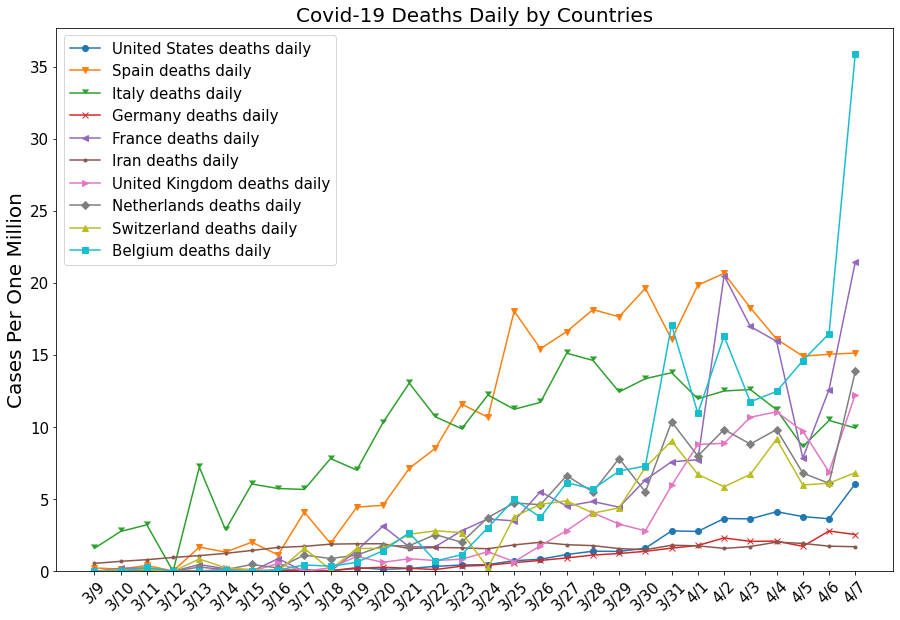

In [234]:
countries_names=["US","Spain","Italy","Germany","France","Iran","United Kingdom","Netherlands","Switzerland","Belgium"]
# countries_names=["China"]
plot=['dd']
plot_countries(countries_names,30,plot,figsize=(15,10),smear_days=0,end_day=0,rescale=True)
# plot_countries(countries_names,36,plot,figsize=(15,10),smear_days=1,end_day=0,rescale=False)

# Data from US

## 1 - Get US data

In [220]:
confirmed_US=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
deaths_US=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
print("The lastest data is: ",confirmed_US.columns[-1])

The lastest data is:  4/7/20


## 2 -  Get data for state/county

In [176]:
def get_US_data(name):
    date=np.array(confirmed_US[confirmed_US['Combined_Key'].str.contains(name,na=False)].iloc[:,11:].columns,dtype=str)
    confirmed=np.array(np.sum(confirmed_US[confirmed_US['Combined_Key'].str.contains(name,na=False)].iloc[:,11:]))
    deaths=np.array(np.sum(deaths_US[deaths_US['Combined_Key'].str.contains(name,na=False)].iloc[:,12:]))
    population=get_population(name)
    with np.errstate(divide='ignore',invalid='ignore'):
        confirmed_rate=confirmed/population
    data=[date,confirmed,deaths,confirmed_rate]
    return data

### Get population by key

In [177]:
def get_population(name):
    a=deaths_US[deaths_US['Combined_Key'].str.contains(name,na=False)]['Population']
    population=np.sum(a)
    return population

## 3 - Plot data

In [178]:
def plot_data(names,days=30,plot=['c'],figsize=(9,7.2),rescale=False):
    plt.figure(figsize=figsize)
        
    SMALL_SIZE = 15
    MEDIUM_SIZE = 25
    BIGGER_SIZE = 35
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    markercycle = cycler(marker=['o', 'v',7, 'x', '<', '.', '>','D','^','s'])
    colorcycle = cycler(color=colors)
    plt.gca().set_prop_cycle(markercycle+colorcycle)
    
    scale=1.0
    for name in names:
        if rescale==True:
            population=get_population(name)
#             if name=="":
#                 population=CountryInfo("United States").population()
            scale=1.0/population*100000
            
        data=get_US_data(name)
        confirmed=data[1]*scale
        d_confirmed=get_derivatives(confirmed)
        deaths=data[2]*scale
        confirmed_rate=data[3]*scale
        d_deaths=get_derivatives(deaths)
        
        date=data[0]
        for i in range(len(date)):
            date[i]=date[i][:-3]        
        if "c" in plot:
            plt.plot(confirmed[-days:],label=name +" total confirmed")
        if "cr" in plot:
            plt.plot(confirmed_rate[-days:]*100,label=name +" confirmed rate")
            plt.ylabel("Percentage")
        if "d" in plot:
            plt.plot(deaths[-days:],label=name +" total deaths")
        if "dc" in plot:
            plt.plot(d_confirmed[-days:],label=name +" confirmed increase")
        if "dd" in plot:
            plt.plot(d_deaths[-days:],label=name +" deaths increase")
    x=range(days)

    
    plt.xticks(x, date[-days:])
    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.title("Covid-19 in US",fontsize=30)
    plt.legend()
    plt.show()

## 4 - Test

### Alachua County

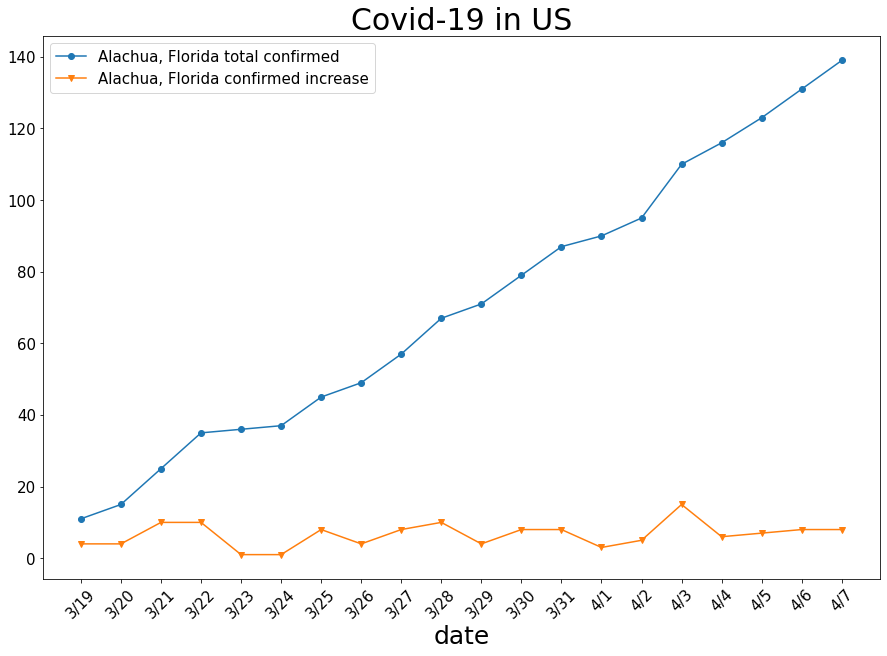

In [179]:
locations=["Alachua, Florida"]
plot_data(locations,20,plot=['c','dc'],figsize=(15,10),rescale=False)

### Get state names

### Get confirmed rate for states

In [180]:
US_state_names=sorted(set(list(confirmed_US['Province_State'])))

In [181]:
data={'State':[],'Population':[],'Confirmed':[],'Deaths':[],'Confirmed_Rate':[]}
df=pd.DataFrame(data)
# for i in range(len(US_state_names)):
i=0
state=US_state_names[i]
population=np.sum(deaths_US[deaths_US['Combined_Key'].str.contains(state+", US",na=False)]['Population'])
confirmed=np.sum(confirmed_US[confirmed_US['Combined_Key'].str.contains(state+", US",na=False)][confirmed_US.columns[-1]])
deaths=np.sum(deaths_US[deaths_US['Combined_Key'].str.contains(state+", US",na=False)][deaths_US.columns[-1]])
with np.errstate(divide='ignore',invalid='ignore'):
    confirmed_rate=confirmed/population
data_tmp={'State':[state],'Population':[population],'Confirmed':[confirmed],'Deaths':[deaths],'Confirmed_Rate':[confirmed_rate]}
df_tmp=pd.DataFrame(data_tmp)
df=df.append(df_tmp,ignore_index=True)
df=np.nan_to_num(df,nan=0,posinf=0)

In [182]:
def get_states_data():
    data={'State':[],'Population':[],'Confirmed':[],'Deaths':[],'Confirmed_Rate':[],'Death_Rate':[]}
    df=pd.DataFrame(data)
    for i in range(len(US_state_names)):
        state=US_state_names[i]
        if state=="District of Columbia":
            key=state+",US"
        else:
            key=state+", US"
        population=np.sum(deaths_US[deaths_US['Combined_Key'].str.contains(key,na=False)]['Population'])
        confirmed=np.sum(confirmed_US[confirmed_US['Combined_Key'].str.contains(key,na=False)][confirmed_US.columns[-1]])
        deaths=np.sum(deaths_US[deaths_US['Combined_Key'].str.contains(key,na=False)][deaths_US.columns[-1]])
        with np.errstate(divide='ignore',invalid='ignore'):
            confirmed_rate=confirmed/population
            confirmed_rate=np.nan_to_num(confirmed_rate,nan=0,posinf=0)
            death_rate=deaths/population
            death_rate=np.nan_to_num(death_rate,nan=0,posinf=0)
        data_tmp={'State':[state],'Population':[population],'Confirmed':[confirmed],'Deaths':[deaths],'Confirmed_Rate':[confirmed_rate],'Death_Rate':[death_rate]}
        df_tmp=pd.DataFrame(data_tmp)
        df=df.append(df_tmp,ignore_index=True)
    return df
df=get_states_data()

### Sort states names by order

In [183]:
sort_key="Confirmed_Rate"
# sort_key="Death_Rate"
# df.sort_values(by=sort_key,ascending=False,ignore_index=True).iloc[:10,:-1]

In [184]:
sort_key="Confirmed_Rate"
ranking=df.sort_values(by=sort_key,ascending=False,ignore_index=True).iloc[:10,0]
states_names=list(ranking)

### States

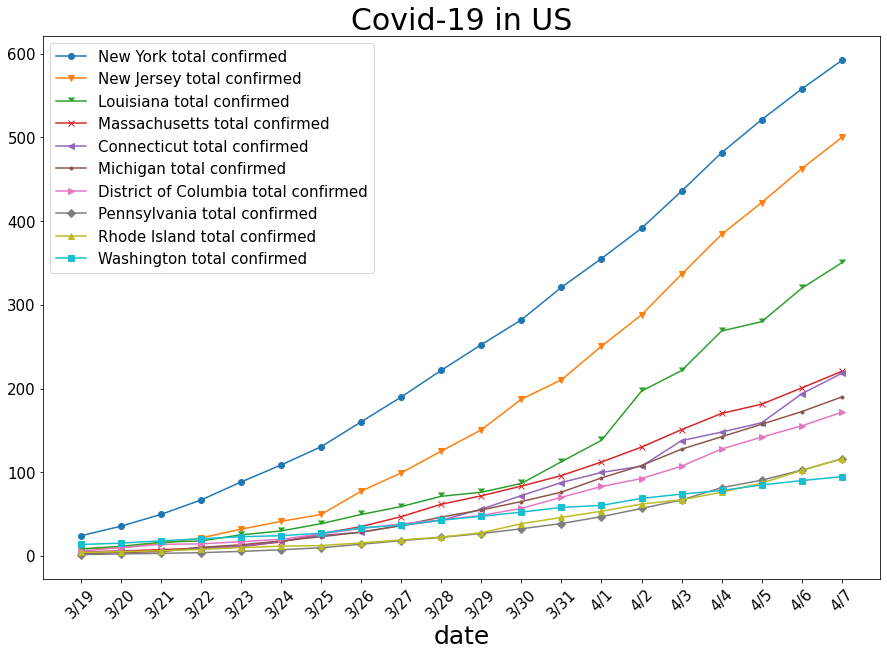

In [185]:
# locations=["New York","New Jersey","Michigan","Florida","Ohio","California",""]
# states_names.append("")
plot_data(states_names,20,plot=['c'],figsize=(15,10),rescale=True)

### Get population

In [221]:
# name="Florida"
def get_population(name):
    a=deaths_US[deaths_US['Combined_Key'].str.contains(name,na=False)]['Population']
    population=np.sum(a)
    return population
# get_population("California")

### Get Florida county population dictionary

In [187]:
state_name="Florida"
def get_population_dict(state_name):
    a=deaths_US[deaths_US['Province_State'].str.contains(state_name,na=False)]
    # b=a.sort_values(by=['Population'],ascending=False).iloc[:50,:]
    population_dict={}
    for i in range(len(a)):
        county_name=a.iloc[i]['Admin2']
        county_population=a.iloc[i]['Population']
        population_dict[county_name]=county_population
    return population_dict
population_dict=get_population_dict(state_name)

### Get population by key

In [222]:
# name="Florida, US"
def get_population(name):
    a=deaths_US[deaths_US['Combined_Key'].str.contains(name,na=False)]
    return np.sum(a.iloc[:]['Population'])

# get_population("Orange, Fl")

### Get confirmed rate dataframe

In [223]:
confirmed_rate_US=pd.DataFrame.copy(confirmed_US)
a=np.array(confirmed_rate_US.iloc[:,11:])
b=np.zeros(len(a))
for i in range(len(a)):
    b[i]=deaths_US.iloc[i]['Population']
b=b.reshape(len(a),1)
with np.errstate(divide='ignore',invalid='ignore'):
    c=np.divide(a,b)
c=np.nan_to_num(c,nan=0,posinf=0)
confirmed_rate_US.iloc[:,11:]=c

# confirmed_rate_US.sort_values(by=confirmed_rate_US.columns[-1],ascending=False,ignore_index=True).iloc[:20,[5,6,-1]]

### Get State county names by order

In [192]:
def get_counties_names(state_name,num=None,ascending=False,order='cr'):
    if order == 'cr':
        a=confirmed_rate_US[confirmed_rate_US['Province_State'].str.contains(state_name,na=False)]
    if order == 'c':
        a=confirmed_US[confirmed_US['Province_State'].str.contains(state_name,na=False)]
    if order == 'd':
        a=deaths_US[deaths_US['Province_State'].str.contains(state_name,na=False)]
    b=a.sort_values(by=[a.columns[-1]],ascending=ascending).iloc[:num,:]
    counties=np.array(b['Admin2'],dtype='<U20')
    for i in range(len(counties)):
        if counties[i]=="New York":
            counties[i]+=" City, "+state_name
        else:
            counties[i]+=", "+state_name
    return list(counties)

### Florida Counties

In [194]:
florida_counties=get_counties_names("Florida",num=9)
florida_counties.append("Alachua")
# florida_counties

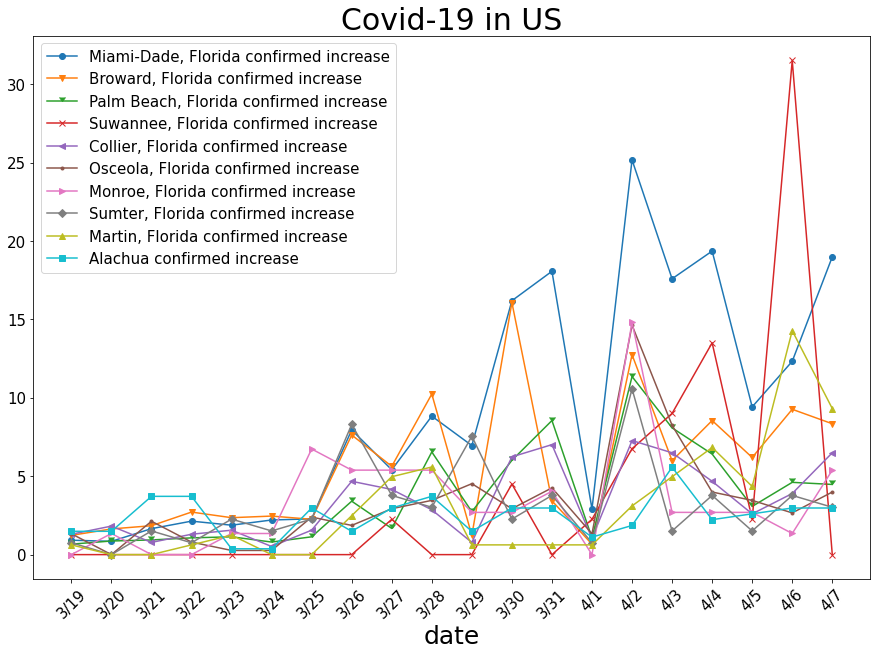

In [199]:
plot_data(florida_counties,20,plot=['dc'],figsize=(15,10),rescale=True)

### Plot the counties in a state in order

In [224]:
def plot_state_by_order(state_name,days=20,plot=['cr'],figsize=(15,10),num=10,ascending=False,order='cr'):
    counties=get_counties_names(state_name,num=num,order=order)
    a=list(counties)
    plot_data(a,days=days,figsize=figsize,plot=[order])

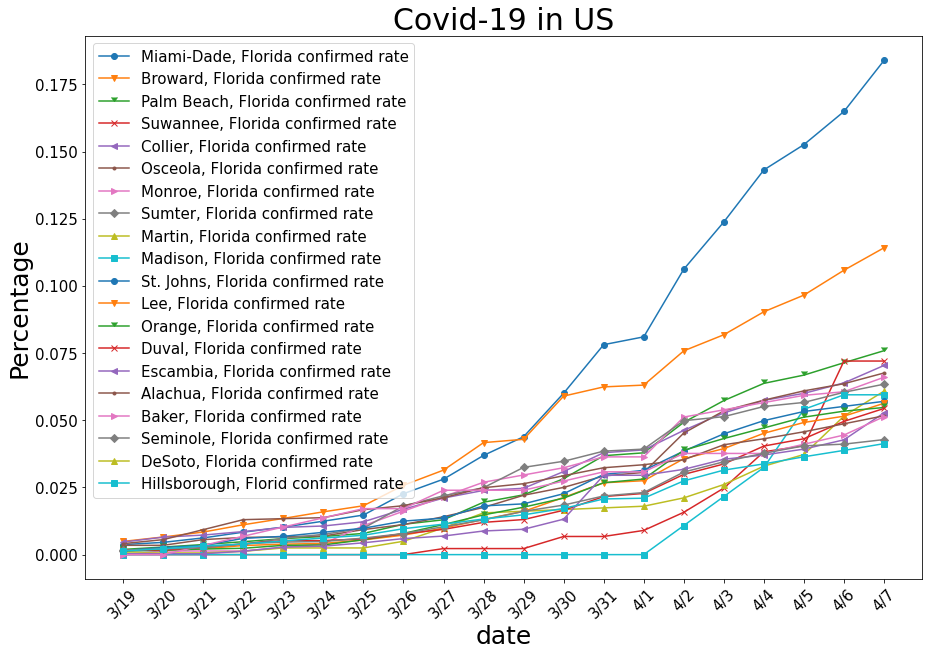

In [225]:
plot_state_by_order("Florida",days=20,plot=['cr'],figsize=(15,10),num=20,ascending=False,order='cr')